In [1]:
import pandas as pd
from pandas import Series, DataFrame
import json 
import os
import requests 
import math
import sqlite3
import copy
import re
import seaborn as sns
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
matplotlib.rcParams.update({'font.size': 15})

In [2]:
#code references for the new data
coderef = pd.read_csv("newbudget1codereferences.csv")
#services provided per planning
planningservice = coderef[coderef["Agency"]== "65 -  PLANNING"].copy()
planningservice.head()

,Organization,Agency,Service,Subservice,Location
513,65101 - PL NEIGH PLAN PRES DESIGN ADMI,65 - PLANNING,651 - NEIGH PLANNING PRES AND DESIGN,6501 - ADMINISTRATION,0000 - UNDEFINED
514,65110 - PL NEIGHBORHOOD PLANNING,65 - PLANNING,651 - NEIGH PLANNING PRES AND DESIGN,6510 - NEIGHBORHOOD PLANNING,0000 - UNDEFINED
515,65111 - PL PRESERVATION PLANNING,65 - PLANNING,651 - NEIGH PLANNING PRES AND DESIGN,6511 - PRESERVATION PLANNING,0000 - UNDEFINED
516,65112 - PL MADISON ARTS PROGRAM,65 - PLANNING,651 - NEIGH PLANNING PRES AND DESIGN,6512 - MADISON ARTS PROGRAM,0000 - UNDEFINED
517,65113 - PL URBAN DESIGN COMMISSION,65 - PLANNING,651 - NEIGH PLANNING PRES AND DESIGN,6513 - URBAN DESIGN COMMISSION,0000 - UNDEFINED


In [3]:
#origional data 
madisonfinancedf = pd.read_csv("budget.csv")
madisonfinancedf.head()

,Agency,Organization,Account Type,Character Code,Object,2015,2016,2017,2018
0,50 - LIBRARY,50100 - LIB PUBLIC SERVICE,Revenue,41 - GENERAL REVENUES,41110 - REAL ESTATE TAXES,-11355535.00,-11941627.00,-12603779.00,-13080447.90
1,50 - LIBRARY,50300 - LIB COL RES & ACCESS,Revenue,41 - GENERAL REVENUES,41110 - REAL ESTATE TAXES,-2056164.00,-2222626.00,-2199357.00,-2268968.77
2,50 - LIBRARY,50400 - LIB FACILITIES,Revenue,41 - GENERAL REVENUES,41110 - REAL ESTATE TAXES,-1766869.00,-1768986.00,-1963404.00,-1976738.18
3,51 - PARKS,51220 - PARK MTC FORESTRY GENERAL,Revenue,49 - TRANSFER IN,49124 - TRANSFER IN FROM OTHER RESTRIC,-1000000.00,-2500000.00,-3100342.25,0.00
4,44 - STREETS,44220 - ST RECYCLING COLLECTION,Revenue,43 - CHARGES FOR SERVICES,43445 - SALE OF RECYCLABLES,-841012.69,-866760.77,-1218608.41,-892803.25


In [4]:
#copy of origional data
mfdf = madisonfinancedf.copy()
mfdf = pd.DataFrame(mfdf)
mfdf = mfdf.sort_values('Agency')
mfdf.head()


,Agency,Organization,Account Type,Character Code,Object,2015,2016,2017,2018
8326,00 - UNDEFINED,110020 - GENERAL FUND EXPENSE,Expense,58 - INTER DEPART BILLING,58180 - ID BILLING TO MONONA TERRACE,NaN,NaN,NaN,0.0
1761,00 - UNDEFINED,110020 - GENERAL FUND EXPENSE,Expense,52 - BENEFITS,52715 - GRANT,0.00,780.68,0.00,0.0
8332,00 - UNDEFINED,110020 - GENERAL FUND EXPENSE,Expense,58 - INTER DEPART BILLING,58186 - ID BILLING TO WATER,NaN,NaN,NaN,0.0
6928,00 - UNDEFINED,110020 - GENERAL FUND EXPENSE,Expense,54 - PURCHASED SERVICES,54645 - CONSULTING SERVICES,68531.03,75298.12,72167.32,83768.3
8331,00 - UNDEFINED,110020 - GENERAL FUND EXPENSE,Expense,58 - INTER DEPART BILLING,58185 - ID BILLING TO TRANSIT,NaN,NaN,NaN,0.0


In [5]:
#Cleaning up the data
mfdf["Agency"] = mfdf["Agency"].str.replace('[^A-Za-z\s]+', '').str.strip()
mfdf["Organization"]= mfdf["Organization"].str.replace('[^A-Za-z\s]+', '').str.strip()
mfdf["Character Code"]= mfdf["Character Code"].str.replace('[^A-Za-z\s]+', '').str.strip()
mfdf["Object"]=mfdf["Object"].str.replace('[^A-Za-z\s]+', '').str.strip()
mfdf.head()

,Agency,Organization,Account Type,Character Code,Object,2015,2016,2017,2018
8326,UNDEFINED,GENERAL FUND EXPENSE,Expense,INTER DEPART BILLING,ID BILLING TO MONONA TERRACE,NaN,NaN,NaN,0.0
1761,UNDEFINED,GENERAL FUND EXPENSE,Expense,BENEFITS,GRANT,0.00,780.68,0.00,0.0
8332,UNDEFINED,GENERAL FUND EXPENSE,Expense,INTER DEPART BILLING,ID BILLING TO WATER,NaN,NaN,NaN,0.0
6928,UNDEFINED,GENERAL FUND EXPENSE,Expense,PURCHASED SERVICES,CONSULTING SERVICES,68531.03,75298.12,72167.32,83768.3
8331,UNDEFINED,GENERAL FUND EXPENSE,Expense,INTER DEPART BILLING,ID BILLING TO TRANSIT,NaN,NaN,NaN,0.0


In [6]:
#data frame for planning yearly budget by charactercodes 
agency = mfdf[mfdf['Agency']=="PLANNING"]
agency1 = mfdf[mfdf['Agency']=="COMMUNITY DEVELOPMENT"]
agencydic= {"2015": {}, "2016": {} , "2017": {} , "2018": {} }
for year in agencydic:
    for code in agency["Organization"]:
        if code not in agencydic[year]:
            a = agency[agency["Organization"]==code]
            summ = a[year].sum()
            agencydic[year][code] = copy.deepcopy(summ)
adf = pd.DataFrame(agencydic["2015"], index=["2015"])
bdf = pd.DataFrame(agencydic["2016"], index=["2016"])
cdf = pd.DataFrame(agencydic["2017"], index=["2017"])
ddf = pd.DataFrame(agencydic["2018"], index=["2018"])
planyearorg = pd.concat([adf, bdf, cdf, ddf])
planyearorg=planyearorg/1000000

planyearorg


,PL METROPOLITAN PLANNING ORG,PL NEIGH PLAN PRES DESIGN ADMI,PL COMP NEIGH SPEC AREA PLAN,PL NEIGHBORHOOD PLANNING,PL TRANSPORTATION PLAN NON MPO,PL COMP PLAN AND DEVELOP ADMIN,PL PRESERVATION PLANNING,PL SPECIAL PROJECTS,PL RESEARCH INFORMATION SERVIC,PL PLAN COMMISSION DEV REVIEW,PL GEO GIS ADMINISTRATION MAIN,PL URBAN DESIGN COMMISSION,PL MADISON ARTS PROGRAM,PL TIF CDA REDEVELOPMENT PLAN,PL DEVELP LAND USE ZONING REG,PL LAND USE POLICY INTERGOV PL
2015,0.283503,0.297465,0.219246,0.252465,0.134689,0.340130,0.109043,0.212096,0.225441,0.296121,0.106075,0.111734,1.942465,0.000000,0.0,0.0
2016,0.258890,0.335264,0.365725,0.281964,0.203631,0.418839,0.108182,0.301593,0.191919,0.236606,0.048955,0.110497,0.182965,0.000000,0.0,0.0
2017,0.140959,0.377865,0.480060,0.360768,0.221787,0.603246,0.117936,0.100695,0.162118,0.196876,0.087631,0.005203,0.218855,0.000025,0.0,0.0
2018,0.094496,0.421926,0.420081,0.377337,0.365577,0.568047,0.078490,0.127823,0.109070,0.298799,0.102560,0.000000,0.202924,0.000000,0.0,0.0


In [7]:
a=planyearorg.transpose()
a.reset_index(level=0, inplace=True)
a["index"]

0       PL METROPOLITAN PLANNING ORG
1     PL NEIGH PLAN PRES DESIGN ADMI
2       PL COMP NEIGH SPEC AREA PLAN
3           PL NEIGHBORHOOD PLANNING
4     PL TRANSPORTATION PLAN NON MPO
5     PL COMP PLAN AND DEVELOP ADMIN
6           PL PRESERVATION PLANNING
7                PL SPECIAL PROJECTS
8     PL RESEARCH INFORMATION SERVIC
9      PL PLAN COMMISSION DEV REVIEW
10    PL GEO GIS ADMINISTRATION MAIN
11        PL URBAN DESIGN COMMISSION
12           PL MADISON ARTS PROGRAM
13     PL TIF CDA REDEVELOPMENT PLAN
14     PL DEVELP LAND USE ZONING REG
15    PL LAND USE POLICY INTERGOV PL
Name: index, dtype: object

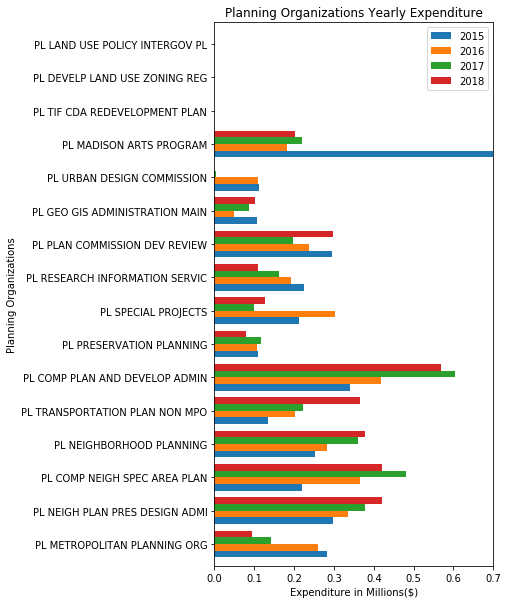

In [8]:
#planning organizations by yearly expenditure horizontal bar 
data=planyearorg.T.plot.barh(figsize=(5,10),title="Planning Organizations Yearly Expenditure", width=0.8) 
data.set_ylabel("Planning Organizations")
data.set_xlabel("Expenditure in Millions($)")
data.set_xlim(0,0.7)
data.legend(loc='upper right')

In [9]:
#http://data-cityofmadison.opendata.arcgis.com/datasets/43743f819e1d4e7ab35a202e442cf27c_28/data
#Data from city of madison on Bus Rapid Routes 
#Planning Transportation MPO
#https://www.cityofmadison.com/dpced/planning/documents/MIM%20priority%20recomendations.pdf
import pandas
from pandas.io.json import json_normalize

res = requests.get("https://opendata.arcgis.com/datasets/43743f819e1d4e7ab35a202e442cf27c_28.geojson")
j = res.json()

dic= []
for object in j["features"]:
    object["properties"]
    object["properties"]["coordinates"]=object["geometry"]["coordinates"]
    dic.append(object["properties"])

pd.DataFrame(dic).to_csv("busrapidtransitstops.csv", encoding='utf-8', index=False)            
rbusdata=pd.read_csv("busrapidtransitstops.csv")
rbusdata=rbusdata.set_index(rbusdata["OBJECTID"])
rbusdata["Notes"] = rbusdata['Notes'].fillna("")
rbusdata["MetroID"] = rbusdata['MetroID'].fillna(0)
rbusdata.head()

,Corridor,LPA,MetroID,Notes,OBJECTID,Type,coordinates,stop_id,stop_lat,stop_lon,stop_name
OBJECTID,,,,,,,,,,,
247,W,1.0,581.0,Relo back from ns Charter,247,main,"[-89.40693696927157, 43.072130688415925]",91002.0,43.072131,-89.406937,EB W JOHNSON fs ORCHARD
248,C,1.0,0.0,,248,main,"[-89.39872296331833, 43.07197055174612]",91003.0,43.071971,-89.398723,EB W JOHNSON fs E CAMPUS MALL
249,C,1.0,883.0,,249,alt,"[-89.38829311063442, 43.07469792125576]",91005.0,43.074698,-89.388293,EB STATE ns FAIRCHILD
250,C,1.0,1101.0,,250,alt,"[-89.38364989768353, 43.07342977575533]",91006.0,43.073430,-89.383650,EB MAIN fs CARROLL
251,C,1.0,1323.0,,251,alt,"[-89.38145786970587, 43.076405813374244]",91007.0,43.076406,-89.381458,EB EAST WASH fs WEBSTER


In [10]:
#number of people commute data 
#http://data-cityofmadison.opendata.arcgis.com/datasets/2bfd47ada14542c5969a6eb7e6f274dd_31/data?geometry=-89.544%2C43.049%2C-89.283%2C43.093
res = requests.get("https://opendata.arcgis.com/datasets/2bfd47ada14542c5969a6eb7e6f274dd_31.geojson")
jj = res.json()

dic= []
for object in jj["features"]:
    object["properties"]
    object["properties"]["coordinates"]=object["geometry"]["coordinates"]
    dic.append(object["properties"])

pd.DataFrame(dic).to_csv("workplacedata.csv", encoding='utf-8', index=False)            
wpdata=pd.read_csv("workplacedata.csv")
wpdata=wpdata.set_index(wpdata["OBJECTID"])
wpdata.head()
#drop duplicates and check len


,Bicycle,Bus,Carpool2,Carpool3,Carpool4,Carpool5,Carpool7,DES_ID,DES_ID_1,DES_LENGTH,...,Rail,ShapeSTLength,Subway,Taxi,Total,Trolley,WORKPLACE,Walked,WorkedHome,coordinates
OBJECTID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,14888.338340,...,0.0,14888.338340,0.0,0.0,10.0,0.0,"Census Tract 10, Dane County, Wisconsin",0.0,0.0,"[[-89.47539185715189, 43.08293455103483], [-89..."
2,0.0,25.0,0.0,0.0,0.0,0.0,0.0,101.0,101.0,7271.941348,...,0.0,7271.941348,0.0,0.0,35.0,0.0,"Census Tract 101, Dane County, Wisconsin",0.0,0.0,"[[-89.47539185715189, 43.08293455103483], [-89..."
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.0,102.0,30090.845436,...,NaN,30090.845436,NaN,NaN,NaN,NaN,"Census Tract 102, Dane County, Wisconsin",NaN,NaN,"[[-89.47539185715189, 43.08293455103483], [-89..."
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.0,103.0,37615.520001,...,NaN,37615.520001,NaN,NaN,NaN,NaN,"Census Tract 103, Dane County, Wisconsin",NaN,NaN,"[[-89.47539185715189, 43.08293455103483], [-89..."
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.0,104.0,39009.663787,...,NaN,39009.663787,NaN,NaN,NaN,NaN,"Census Tract 104, Dane County, Wisconsin",NaN,NaN,"[[-89.47539185715189, 43.08293455103483], [-89..."


In [11]:
#NEED HELP INTERPERETING the rapid bus dicionary snippet. In the above codes, I copied the gemetry{"coordinates"} 
#and input them in the new properties{"coordinates"}. That is why there are two identical coordinates. 
#
for object in j["features"]:
    print(object)
    break
#NEED HELP INTERPERETING the commute dicionary snippet.
for object in jj["features"]:
    print(object)
    break

{'type': 'Feature', 'properties': {'OBJECTID': 247, 'stop_id': 91002, 'stop_name': 'EB W JOHNSON fs ORCHARD', 'stop_lat': 43.07213069, 'stop_lon': -89.40693697, 'MetroID': 581, 'Notes': 'Relo back from ns Charter', 'Type': 'main', 'Corridor': 'W', 'LPA': 1, 'coordinates': [-89.40693696927157, 43.072130688415925]}, 'geometry': {'type': 'Point', 'coordinates': [-89.40693696927157, 43.072130688415925]}}
{'type': 'Feature', 'properties': {'OBJECTID': 1, 'ORG_ID': '1', 'DES_ID': '10', 'DES_LENGTH': 14888.33833972, 'ORG_DES_ID': '1_10', 'OBJECTID_1': 2141, 'WORKPLACE': 'Census Tract 10, Dane County, Wisconsin', 'RESIDENCE': 'Census Tract 1, Dane County, Wisconsin', 'Total': 10, 'DroveAlone': 10, 'Carpool2': 0, 'Carpool3': 0, 'Carpool4': 0, 'Carpool5': 0, 'Carpool7': 0, 'Bus': 0, 'Trolley': 0, 'Subway': 0, 'Rail': 0, 'Ferry': 0, 'Bicycle': 0, 'Walked': 0, 'Taxi': 0, 'Motorcycle': 0, 'Other': 0, 'WorkedHome': 0, 'ORG_ID_1': '1', 'DES_ID_1': '10', 'ORG_DES_ID_1': '1_10', 'ShapeSTLength': 14888.

In [12]:
#data clean up 
dic = []
for coor in wpdata["coordinates"]:
    coor = str(coor)
    coor = coor.replace("[", "")
    coor = coor.replace("]", "")
    coor = coor.replace(",", "")
    #coor = coor.replace("-", "")
    coor = coor.split()
    dic.append(coor)
wpdata["coordinates"] = dic
dic = []
for coor in rbusdata["coordinates"]:
    coor = str(coor)
    coor = coor.replace("[", "")
    coor = coor.replace("]", "")
    coor = coor.replace(",", "")
    #coor = coor.replace("-", "")
    coor = coor.split()
    dic.append(coor)
rbusdata["coordinates"] = dic
wpdata.head()

,Bicycle,Bus,Carpool2,Carpool3,Carpool4,Carpool5,Carpool7,DES_ID,DES_ID_1,DES_LENGTH,...,Rail,ShapeSTLength,Subway,Taxi,Total,Trolley,WORKPLACE,Walked,WorkedHome,coordinates
OBJECTID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,14888.338340,...,0.0,14888.338340,0.0,0.0,10.0,0.0,"Census Tract 10, Dane County, Wisconsin",0.0,0.0,"[-89.47539185715189, 43.08293455103483, -89.43..."
2,0.0,25.0,0.0,0.0,0.0,0.0,0.0,101.0,101.0,7271.941348,...,0.0,7271.941348,0.0,0.0,35.0,0.0,"Census Tract 101, Dane County, Wisconsin",0.0,0.0,"[-89.47539185715189, 43.08293455103483, -89.44..."
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.0,102.0,30090.845436,...,NaN,30090.845436,NaN,NaN,NaN,NaN,"Census Tract 102, Dane County, Wisconsin",NaN,NaN,"[-89.47539185715189, 43.08293455103483, -89.37..."
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.0,103.0,37615.520001,...,NaN,37615.520001,NaN,NaN,NaN,NaN,"Census Tract 103, Dane County, Wisconsin",NaN,NaN,"[-89.47539185715189, 43.08293455103483, -89.33..."
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.0,104.0,39009.663787,...,NaN,39009.663787,NaN,NaN,NaN,NaN,"Census Tract 104, Dane County, Wisconsin",NaN,NaN,"[-89.47539185715189, 43.08293455103483, -89.33..."


In [ ]:
#choosing locations that are 10 min away from bus stop from wpdata 
# approximate radius of earth in km
#ref https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
from math import sin, cos, sqrt, atan2, radians
dic= []
R = 6373.0
#for _, row in df.iterrows():
 #coordinates = row["coordinates"] 
    
for index in wpdata["OBJECTID"]:
    coordinates = wpdata[wpdata["OBJECTID"] == index]
    coordinates = coordinates["coordinates"]
    for bcoor in rbusdata["coordinates"]:
        for coor in coordinates:                    
            lat1 = radians(float(coor[1]))
            lon1 = radians(float(coor[0]))
            lat2 = radians(float(bcoor[1]))
            lon2 = radians(float(bcoor[0]))
            dlon = lon2 - lon1
            dlat = lat2 - lat1
            a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            distance = R * c
            if distance <= 0.6:
                for bcoorr in rbusdata["coordinates"]:
                    lat1 = radians(float(coor[3]))
                    lon1 = radians(float(coor[2]))
                    lat2 = radians(float(bcoorr[1]))
                    lon2 = radians(float(bcoorr[0]))
                    dlon = lon2 - lon1
                    dlat = lat2 - lat1
                    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
                    c = 2 * atan2(sqrt(a), sqrt(1 - a))
                    distance = R * c
                    if distance <= 0.6:
                        dic.append(wpdata[wpdata["OBJECTID"]==index])
                       
datas=pd.concat(dic)
datas.head()                    
            

        

In [ ]:
data = copy.deepcopy(datas)
data=data.drop_duplicates(subset=["OBJECTID"], keep="first")
data

    

In [ ]:
data.sort_values(by="Bus", ascending=False)
data1 = copy.deepcopy(data)
data1.drop('DES_ID', axis=1, inplace=True)
data1.drop('DES_ID_1', axis=1, inplace=True)
data1.drop('DES_LENGTH', axis=1, inplace=True)
data1.drop('OBJECTID_1', axis=1, inplace=True)
data1.drop('OBJECTID', axis=1, inplace=True)
data1.drop('ORG_DES_ID', axis=1, inplace=True)
data1.drop('ORG_DES_ID_1', axis=1, inplace=True)
data1.drop('ORG_ID', axis=1, inplace=True)
data1.drop('ORG_ID_1', axis=1, inplace=True)
data1.drop('RESIDENCE', axis=1, inplace=True)
data1.drop('ShapeSTLength', axis=1, inplace=True)
data1.drop('WORKPLACE', axis=1, inplace=True)
data1.drop('coordinates', axis=1, inplace=True)
data1=data1.sum()
print(data1)
fig, ax = subplots()
dataplot1=data1.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops",xlim=(0,7000), ax=ax) 
dataplot1
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
dataplot1.set_xlabel("Number of commuters")

In [ ]:
#eliminating people who have work 10 min distance from their home
# approximate radius of earth in km
#ref https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
from math import sin, cos, sqrt, atan2, radians
dic= []
dic20= []
dic30=[]
R = 6373.0
#for _, row in df.iterrows():
 #coordinates = row["coordinates"] 
    
for index in data["OBJECTID"]:
    coordinates = data[data["OBJECTID"] == index]
    coordinates = coordinates["coordinates"]
    for coor in coordinates:                    
        lat1 = radians(float(coor[1]))
        lon1 = radians(float(coor[0]))
        lat2 = radians(float(coor[3]))
        lon2 = radians(float(coor[2]))
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = R * c
        if 0.6 <= distance:
            dic.append(data[data["OBJECTID"]==index])
        if 1.2 <= distance:
            dic20.append(data[data["OBJECTID"]==index])
        if 1.8 <= distance:
            dic30.append(data[data["OBJECTID"]==index])            
data3=pd.concat(dic20)
data4=pd.concat(dic30)
data2=pd.concat(dic)
data2                    
            

        

In [ ]:
data2.sort_values(by="Bus", ascending=False)
data2 = copy.deepcopy(data2)
data2.drop('DES_ID', axis=1, inplace=True)
data2.drop('DES_ID_1', axis=1, inplace=True)
data2.drop('DES_LENGTH', axis=1, inplace=True)
data2.drop('OBJECTID_1', axis=1, inplace=True)
data2.drop('OBJECTID', axis=1, inplace=True)
data2.drop('ORG_DES_ID', axis=1, inplace=True)
data2.drop('ORG_DES_ID_1', axis=1, inplace=True)
data2.drop('ORG_ID', axis=1, inplace=True)
data2.drop('ORG_ID_1', axis=1, inplace=True)
data2.drop('RESIDENCE', axis=1, inplace=True)
data2.drop('ShapeSTLength', axis=1, inplace=True)
data2.drop('WORKPLACE', axis=1, inplace=True)
data2.drop('coordinates', axis=1, inplace=True)
data2=data2.sum()
print(data2)
fig, ax = subplots()
dataplot2=data2.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops",xlim=(0,7000), ax=ax) 
dataplot2
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
dataplot2.set_xlabel("Number of commuters")

In [ ]:
data3.sort_values(by="Bus", ascending=False)
data3 = copy.deepcopy(data3)
data3.drop('DES_ID', axis=1, inplace=True)
data3.drop('DES_ID_1', axis=1, inplace=True)
data3.drop('DES_LENGTH', axis=1, inplace=True)
data3.drop('OBJECTID_1', axis=1, inplace=True)
data3.drop('OBJECTID', axis=1, inplace=True)
data3.drop('ORG_DES_ID', axis=1, inplace=True)
data3.drop('ORG_DES_ID_1', axis=1, inplace=True)
data3.drop('ORG_ID', axis=1, inplace=True)
data3.drop('ORG_ID_1', axis=1, inplace=True)
data3.drop('RESIDENCE', axis=1, inplace=True)
data3.drop('ShapeSTLength', axis=1, inplace=True)
data3.drop('WORKPLACE', axis=1, inplace=True)
data3.drop('coordinates', axis=1, inplace=True)
data3=data3.sum()
print(data3)
fig, ax = subplots()
dataplot3=data3.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops",xlim=(0,7000), ax=ax) 
dataplot3
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
dataplot3.set_xlabel("Number of commuters")

In [ ]:
data4.sort_values(by="Bus", ascending=False)
data4 = copy.deepcopy(data4)
datafour = copy.deepcopy(data4)
data4.drop('DES_ID', axis=1, inplace=True)
data4.drop('DES_ID_1', axis=1, inplace=True)
data4.drop('DES_LENGTH', axis=1, inplace=True)
data4.drop('OBJECTID_1', axis=1, inplace=True)
data4.drop('OBJECTID', axis=1, inplace=True)
data4.drop('ORG_DES_ID', axis=1, inplace=True)
data4.drop('ORG_DES_ID_1', axis=1, inplace=True)
data4.drop('ORG_ID', axis=1, inplace=True)
data4.drop('ORG_ID_1', axis=1, inplace=True)
data4.drop('RESIDENCE', axis=1, inplace=True)
data4.drop('ShapeSTLength', axis=1, inplace=True)
data4.drop('WORKPLACE', axis=1, inplace=True)
data4.drop('coordinates', axis=1, inplace=True)
data4=data4.sum()
print(data4)
fig, ax = subplots()
dataplot4=data4.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops",xlim=(0,7000), ax=ax) 
dataplot4
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
dataplot4.set_xlabel("Number of commuters")

In [ ]:
#number of commute comparrason 
stack=pd.concat([data1, data2, data3, data4],axis=1, join_axes=[data1.index])
stack=pd.DataFrame(stack)
stack.columns = ['None', '10 min', '20 min', "30 min"]
stack=stack.transpose()

stack.drop('Total', axis=1, inplace=True)

stack10min = copy.deepcopy(stack) 

In [ ]:
stack.drop('Rail', axis=1, inplace=True)
stack.drop('Other', axis=1, inplace=True)
stack.drop('Motorcycle', axis=1, inplace=True)
stack.drop('Ferry', axis=1, inplace=True)
stack.drop('Carpool7', axis=1, inplace=True)
stack.drop('Carpool5', axis=1, inplace=True)
stack.drop('Carpool4', axis=1, inplace=True)
stack.drop('WorkedHome', axis=1, inplace=True)
stack.drop('Trolley', axis=1, inplace=True)
stack.drop('Taxi', axis=1, inplace=True)
stack.drop('Subway', axis=1, inplace=True)

In [ ]:
fig, ax = subplots()

stackplot=stack.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops with walking distance limit",xlim=(0,7000), ax=ax) 
stackplot
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
stackplot.set_xlabel("Number of commuters")

In [ ]:
#percentage of commute 
data1=data1/data1["Total"]
data2=data2/data2["Total"]
data3=data3/data3["Total"]
data4=data4/data4["Total"]
stack=pd.concat([data1, data2, data3, data4],axis=1, join_axes=[data1.index])
stack=pd.DataFrame(stack)
stack.columns = ['Total', '10 min', '20 min', "30 min"]
stack=stack.transpose()
stack.drop('Total', axis=1, inplace=True)
stack10minper = copy.deepcopy(stack)

In [ ]:
stack.drop('WorkedHome', axis=1, inplace=True)
stack.drop('Trolley', axis=1, inplace=True)
stack.drop('Taxi', axis=1, inplace=True)
stack.drop('Subway', axis=1, inplace=True)

stack.drop('Rail', axis=1, inplace=True)
stack.drop('Other', axis=1, inplace=True)
stack.drop('Motorcycle', axis=1, inplace=True)
stack.drop('Ferry', axis=1, inplace=True)
stack.drop('Carpool7', axis=1, inplace=True)
stack.drop('Carpool5', axis=1, inplace=True)
stack.drop('Carpool4', axis=1, inplace=True)

In [ ]:
fig, ax = subplots()

stackplot=stack.T.plot.barh(figsize=(5,10),title="Percentage of commute per total Commute",xlim=(0,0.6), ax=ax) 
stackplot
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
stackplot.set_xlabel("Number of commuters")

In [ ]:
misc=-(stack.transpose().sum()-1)
stack["Misc"] = misc


In [ ]:
fig, ax = subplots()
stackplot=stack.transpose().T.plot.bar(figsize=(10,10),xlim=(0,1.0), stacked= True, title="Percentage of commute per total Commute", fontsize=15, ax=ax)
stackplot.legend(title='Commute method', bbox_to_anchor=(1, 0.5), fontsize = 15)


In [ ]:
import pandas as pd
import geopandas # we'll use this to read shapefiles
from shapely.geometry import Point

# the City_Limit directory contains some shapefiles.
# downloaded from here: http://data-cityofmadison.opendata.arcgis.com/datasets/city-limit
madison = geopandas.read_file("City_Limit")
madison.head()


In [ ]:
# downloaded from here: http://data-cityofmadison.opendata.arcgis.com/datasets/c46082b091a941f8b2ded1dd115a1a05_8
lakes = geopandas.read_file("Lakes_and_Rivers")
lakes.head()

In [ ]:
ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="blue", ax=ax)

In [ ]:
# now lets annotate some buildings
coords = pd.Series([
    Point(-89.406749, 43.071478), # CS building
    Point(-89.384054, 43.074617), # Capital
])
print(coords)
buildings = pd.DataFrame({"Coordinates": coords})
buildings = geopandas.GeoDataFrame(buildings, geometry='Coordinates')
buildings

In [ ]:
ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="blue", ax=ax)
buildings.plot(color="red", ax=ax)

In [ ]:
#annotate rapid bus stops 
dic = []
for coor in rbusdata["coordinates"]:
    dic.append(Point(float(coor[0]),float(coor[1])))
coords = pd.Series(dic)
bs = pd.DataFrame({"Coordinates": coords})
bs = geopandas.GeoDataFrame(bs, geometry='Coordinates')


ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="blue", ax=ax)
buildings.plot(color="red", ax=ax)
bs.plot(color="black", ax=ax)

In [ ]:
homedic = []
for coor in data["coordinates"]:
    homedic.append(Point(float(coor[0]),float(coor[1])))
hcoords = pd.Series(homedic)
hcoords.head()

In [ ]:
#annotate commute data  
homedic = []
for coor in data["coordinates"]:
    homedic.append(Point(float(coor[0]),float(coor[1])))
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')

workdic = []
for coor in data["coordinates"]:
    workdic.append(Point(float(coor[2]),float(coor[3])))
wcoords = pd.Series(workdic)
ws = pd.DataFrame({"Coordinates": wcoords})
ws = geopandas.GeoDataFrame(ws, geometry='Coordinates')

ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="blue", ax=ax)
bs.plot(color="black", ax=ax)
hs.plot(color="green", ax=ax)


In [ ]:
#annotate commute data  
homedic = []
for coor in data["coordinates"]:
    homedic.append(Point(float(coor[0]),float(coor[1])))
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')

workdic = []
for coor in data["coordinates"]:
    workdic.append(Point(float(coor[2]),float(coor[3])))
wcoords = pd.Series(workdic)
ws = pd.DataFrame({"Coordinates": wcoords})
ws = geopandas.GeoDataFrame(ws, geometry='Coordinates')

ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="blue", ax=ax)
bs.plot(color="black", ax=ax)
hs.plot(color="green", ax=ax)
ws.plot(color="red", ax=ax)
#apparently, the work place and home coordinates are exactly the same so it overlaps, 
#only making one of the colors show... what?!

In [ ]:
#annotate commute data from the origional wpdata
homedic = []
for coor in wpdata["coordinates"]:
    homedic.append(Point(float(coor[0]),float(coor[1])))
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')

workdic = []
for coor in wpdata["coordinates"]:
    workdic.append(Point(float(coor[2]),float(coor[3])))
wcoords = pd.Series(workdic)
ws = pd.DataFrame({"Coordinates": wcoords})
ws = geopandas.GeoDataFrame(ws, geometry='Coordinates')

ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="blue", ax=ax)
bs.plot(color="black", ax=ax)
hs.plot(color="green", ax=ax)
ws.plot(color="red", ax=ax)
#again did not print due to the overlap. What is going on?? 

In [ ]:
#annotate commute data from the origional wpdata
homedic = []
for coor in wpdata["coordinates"]:
    homedic.append(Point(float(coor[0]),float(coor[1])))
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')

workdic = []
for coor in wpdata["coordinates"]:
    workdic.append(Point(float(coor[2]),float(coor[3])))
wcoords = pd.Series(workdic)
ws = pd.DataFrame({"Coordinates": wcoords})
ws = geopandas.GeoDataFrame(ws, geometry='Coordinates')

ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="blue", ax=ax)
bs.plot(color="black", ax=ax)
hs.plot(color="green", ax=ax)
ws.plot(color="red", ax=ax)
#again did not print due to the overlap. What is going on?? 

In [ ]:
#annotate commute data from the origional wpdata
#making the dots bigger according to travel size 
#reference_____https://pynative.com/python-generate-random-string/
#reference_____http://jonathansoma.com/lede/foundations-2017/classes/geopandas/mapping-with-geopandas/
#mport random
#import string
ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)
print(len(data))
data.fillna(0, inplace=True)
dic = range(0, 380)
dic = list(dic)
i = 0
for index in data["OBJECTID"]:
    locat = data[data["OBJECTID"]==index]
    coordinates = locat["coordinates"]
    for coor in coordinates:
        homedic = []
        homedic.append(Point(float(coor[0]),float(coor[1])))
        hcoords = pd.Series(homedic)
        hs = pd.DataFrame({"Coordinates": hcoords})
        hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
        total = locat["Total"]
        pop=float(total)*5
        dic[i] = hs
        #print(pop)
        #lettersAndDigits = string.ascii_letters + string.digits
        #counter =''.join(random.choice(lettersAndDigits) for i in range(10))
        #counter = hs
        dic[i].plot(color="pink", ax=ax, markersize=pop, alpha=0.25)
        i += 1
        

        
         
    
    


 


In [ ]:
#################draw lines between the two coordinates to check relevence######################

#making the dots bigger according to travel size 
#reference_____https://pynative.com/python-generate-random-string/
#reference_____http://jonathansoma.com/lede/foundations-2017/classes/geopandas/mapping-with-geopandas/
#import random
#import string
from shapely.geometry import LineString

ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)

data.fillna(0, inplace=True)
homedic = []
for index in data["OBJECTID"]:
    locat = data[data["OBJECTID"]==index]
    coordinates = locat["coordinates"]
    for coor in coordinates:
        homedic.append(LineString([(float(coor[0]), float(coor[1])), (float(coor[2]), float(coor[3]))]))     
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
hs.plot(color="red", ax=ax, alpha=0.25)

        

In [ ]:
#cleaning up NaN in origional wpdata
wpdata.fillna(0, inplace=True)
wpdata.head()

In [ ]:
#commuting from entire wpdata 
from shapely.geometry import LineString


homedic = []
for index in wpdata["OBJECTID"]:
    locat = wpdata[wpdata["OBJECTID"]==index]
    coordinates = locat["coordinates"]
    for coor in coordinates:
        homedic.append(LineString([(float(coor[0]), float(coor[1])), (float(coor[2]), float(coor[3]))]))             


In [ ]:
ax = madison.plot(color="gray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
hs.plot(color="red", ax=ax, alpha=0.01)

In [ ]:
import random
import string
lettersAndDigits = string.ascii_letters + string.digits
count=''.join(random.choice(lettersAndDigits) for i in range(10))
count

In [ ]:
#http://data-cityofmadison.opendata.arcgis.com/datasets/3afa8d889c8541ec8cbd89c5845921a2_26
#2015 ridership data by stops

res = requests.get("https://opendata.arcgis.com/datasets/3afa8d889c8541ec8cbd89c5845921a2_26.geojson")
j = res.json()
dic= []
for object in j["features"]:
    object["properties"]
    object["properties"]["coordinates"]=object["geometry"]["coordinates"]
    dic.append(object["properties"])

pd.DataFrame(dic).to_csv("rideship2015.csv", encoding='utf-8', index=False)            #
ride15=pd.read_csv("rideship2015.csv")
ride15=ride15.set_index(ride15["OBJECTID"])
ride15

In [ ]:
#http://data-cityofmadison.opendata.arcgis.com/items/3afa8d889c8541ec8cbd89c5845921a2
#2017 ridership data by stops

res = requests.get("https://maps.cityofmadison.com/arcgis/rest/services/Public/OPEN_DATA_TRANS/MapServer/26/query?outFields=*&where=1%3D1&f=geojson")
j = res.json()
dic= []
for object in j["features"]:
    object["properties"]
    object["properties"]["coordinates"]=object["geometry"]["coordinates"]
    dic.append(object["properties"])

pd.DataFrame(dic).to_csv("rideship2017.csv", encoding='utf-8', index=False)            #
ride17=pd.read_csv("rideship2017.csv")
ride17=ride17.set_index(ride17["OBJECTID"])
ride17

In [ ]:
# preparing presentation 
# how do people get to work 
# how laxy are people when it comes to biking and walking
#which neighborhoods make the most use of public transportation
#if we could add one bus line, what would it be? 

In [ ]:
#finding the biggest commute coordinates 
dic= []
dicc =[]
diccc= []
for i in data["coordinates"]:
    longitude = i[0]
    latitude = i[1]
    dic.append(longitude)
    diccc.append(latitude)

dic = pd.DataFrame(dic)
mindic = dic.min()
maxdic = dic.max()

diccc = pd.DataFrame(diccc)
mindiccc = diccc.min()
print(mindiccc)
maxdiccc = diccc.max()

coordinates=wpdata["coordinates"]
for i in coordinates:
    dicc.append(i)
dicc = pd.DataFrame(dicc)

mincoor =dicc[dicc[0]==str(mindic[0])]
mincoor['index1'] = mincoor.index

maxcoor = dicc[dicc[0]==str(maxdic[0])]
maxcoor["index1"] = maxcoor.index

mincoorlat =dicc[dicc[1]==str(mindiccc[0])]
mincoorlat['index1'] = mincoorlat.index
mincoorlat.head()
maxcoorlat = dicc[dicc[1]==str(maxdiccc[0])]
maxcoorlat["index1"] = maxcoorlat.index
maxcoorlat.head()

In [ ]:
#most northern
from shapely.geometry import LineString


homedic = []
for index in maxcoorlat["index1"]:
    locat = maxcoorlat[maxcoorlat["index1"]==index]
    homedic.append(LineString([(locat[0], locat[1]), (locat[2], locat[3])]))             
ax = madison.plot(color="gray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
hs.plot(color="red", ax=ax, alpha=0.5)    
    

In [ ]:
#most south
from shapely.geometry import LineString


homedic = []
for index in mincoorlat["index1"]:
    locat = mincoorlat[mincoorlat["index1"]==index]
    homedic.append(LineString([(locat[0], locat[1]), (locat[2], locat[3])]))             
ax = madison.plot(color="gray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
hs.plot(color="red", ax=ax, alpha=0.5)    
    

In [ ]:
#most east
from shapely.geometry import LineString


homedic = []
for index in mincoor["index1"]:
    locat = mincoor[mincoor["index1"]==index]
    homedic.append(LineString([(locat[0], locat[1]), (locat[2], locat[3])]))             
ax = madison.plot(color="gray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
hs.plot(color="red", ax=ax, alpha=0.5)    
    
             


In [ ]:
#most west
from shapely.geometry import LineString


homedic = []
for index in maxcoor["index1"]:
    locat = maxcoor[maxcoor["index1"]==index]
    homedic.append(LineString([(locat[0], locat[1]), (locat[2], locat[3])]))             
ax = madison.plot(color="gray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
hs.plot(color="red", ax=ax, alpha=0.5)
    
    
    
 

In [ ]:
wpdata

In [ ]:
dic=[]
for i in wpdata["coordinates"]:
    dic.append(i)



In [ ]:
fourmile=pd.read_csv("fourmile.csv")
fourmile

In [ ]:
for coor in fourmile["coordinates"]:
    print(coor)
    coor = str(coor)
    coor = coor.replace("[", "")
    coor = coor.replace("]", "")
    coor = coor.replace(",", "")
    #coor = coor.replace("-", "")
    coor = coor.replace("'", "")
    coor = coor.split()
    coorr = [float(coor[0]), float(coor[1]), float(coor[2]), float(coor[3])]


In [ ]:
#data clean up 
dic = []
for coor in fourmile["coordinates"]:
    coor = str(coor)
    coor = coor.replace("[", "")
    coor = coor.replace("]", "")
    coor = coor.replace(",", "")
    coor = coor.replace("'", "")
    coor = coor.split()
    coorr = [float(coor[0]), float(coor[1]), float(coor[2]), float(coor[3])]
    dic.append(coorr)
fourmile["coordinates"] = dic
fourmile

In [ ]:
for coor in fourmile["coordinates"]:
    print(coor[2])

In [ ]:
fourmile1 = copy.deepcopy(fourmile)

In [ ]:
#eliminating people who have work 10, 30, hour min distance from their home
# approximate radius of earth in km
#ref https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
from math import sin, cos, sqrt, atan2, radians
dic10= []
dic30= []
dic60=[]
R = 6373.0

#for _, row in df.iterrows():
 #coordinates = row["coordinates"] 
    
for index in fourmile1["OBJECTID"]:
    coordinates = fourmile1[fourmile1["OBJECTID"] == index]
    coordinates = coordinates["coordinates"]
    for coor in coordinates:                    
        lat1 = radians(float(coor[1]))
        lon1 = radians(float(coor[0]))
        lat2 = radians(float(coor[3]))
        lon2 = radians(float(coor[2]))
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = R * c
        if  0.6<= distance:
            dic10.append(fourmile1[fourmile1["OBJECTID"]==index])
        if 1.8 <= distance:
            dic30.append(fourmile1[fourmile1["OBJECTID"]==index])
        if 3.2 <= distance:
            dic60.append(fourmile1[fourmile1["OBJECTID"]==index])            
data3=pd.concat(dic30)
data4=pd.concat(dic60)
data2=pd.concat(dic10)
data3=data3.drop_duplicates(subset=["OBJECTID"], keep="first")                 
data4=data4.drop_duplicates(subset=["OBJECTID"], keep="first")   
data2=data2.drop_duplicates(subset=["OBJECTID"], keep="first")

In [ ]:
fourmile1.sort_values(by="Bus", ascending=False)
fourmile1.drop('DES_ID', axis=1, inplace=True)
fourmile1.drop('DES_ID_1', axis=1, inplace=True)
fourmile1.drop('DES_LENGTH', axis=1, inplace=True)
fourmile1.drop('OBJECTID_1', axis=1, inplace=True)
fourmile1.drop('OBJECTID', axis=1, inplace=True)
fourmile1.drop('ORG_DES_ID', axis=1, inplace=True)
fourmile1.drop('ORG_DES_ID_1', axis=1, inplace=True)
fourmile1.drop('ORG_ID', axis=1, inplace=True)
fourmile1.drop('ORG_ID_1', axis=1, inplace=True)
fourmile1.drop('RESIDENCE', axis=1, inplace=True)
fourmile1.drop('ShapeSTLength', axis=1, inplace=True)
fourmile1.drop('WORKPLACE', axis=1, inplace=True)
fourmile1.drop('coordinates', axis=1, inplace=True)
circledata=copy.deepcopy(fourmile1)
fourmile1=fourmile1.sum()
print(fourmile1)
#fig, ax = subplots()
#wpdata1plot1=wpdata1.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops",xlim=(0,7000), ax=ax) 
#wpdata1plot1
#ax.annotate('',(70, 13))
#ax.annotate('',(70, 15))
#wpdata1plot1.set_xlabel("Number of commuters")

In [ ]:
circledata=circledata/fourmile1["Total"]
circledata.drop('WorkedHome', axis=1, inplace=True)
circledata.drop('Trolley', axis=1, inplace=True)
circledata.drop('Taxi', axis=1, inplace=True)
circledata.drop('Subway', axis=1, inplace=True)
circledata.drop('Rail', axis=1, inplace=True)
circledata.drop('Other', axis=1, inplace=True)
circledata.drop('Motorcycle', axis=1, inplace=True)
circledata.drop('Ferry', axis=1, inplace=True)
circledata.drop('Carpool7', axis=1, inplace=True)
circledata.drop('Carpool5', axis=1, inplace=True)
circledata.drop('Carpool4', axis=1, inplace=True)
circledata.drop('Total', axis=1, inplace=True)
circledata=circledata.sum()


In [ ]:
misc=-(circledata.transpose().sum()-1)
circledata["Misc"] = misc

In [ ]:
circledata

In [ ]:
fig, ax = subplots()

circleplot=circledata.plot.pie(figsize=(10,10),title="Total Commute Ratio", ax=ax, fontsize=20) 

circleplot.set_ylabel("")
dataplot3.set_xlabel("")

In [ ]:
#annotate commute data  
homedic = []
for coor in data3["coordinates"]:
    homedic.append(Point(float(coor[0]),float(coor[1])))
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')

ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="blue", ax=ax)
bs.plot(color="black", ax=ax)
hs.plot(color="green", ax=ax)


In [ ]:
data2.sort_values(by="Bus", ascending=False)
data2 = copy.deepcopy(data2)
data2.drop('DES_ID', axis=1, inplace=True)
data2.drop('DES_ID_1', axis=1, inplace=True)
data2.drop('DES_LENGTH', axis=1, inplace=True)
data2.drop('OBJECTID_1', axis=1, inplace=True)
data2.drop('OBJECTID', axis=1, inplace=True)
data2.drop('ORG_DES_ID', axis=1, inplace=True)
data2.drop('ORG_DES_ID_1', axis=1, inplace=True)
data2.drop('ORG_ID', axis=1, inplace=True)
data2.drop('ORG_ID_1', axis=1, inplace=True)
data2.drop('RESIDENCE', axis=1, inplace=True)
data2.drop('ShapeSTLength', axis=1, inplace=True)
data2.drop('WORKPLACE', axis=1, inplace=True)
data2.drop('coordinates', axis=1, inplace=True)
data2=data2.sum()
print(data2)
#fig, ax = subplots()
#dataplot2=data2.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops",xlim=(0,7000), ax=ax) 
#dataplot2
#ax.annotate('',(70, 13))
#ax.annotate('',(70, 15))
#dataplot2.set_xlabel("Number of commuters")

In [ ]:
data3.sort_values(by="Bus", ascending=False)
data3 = copy.deepcopy(data3)
data3.drop('DES_ID', axis=1, inplace=True)
data3.drop('DES_ID_1', axis=1, inplace=True)
data3.drop('DES_LENGTH', axis=1, inplace=True)
data3.drop('OBJECTID_1', axis=1, inplace=True)
data3.drop('OBJECTID', axis=1, inplace=True)
data3.drop('ORG_DES_ID', axis=1, inplace=True)
data3.drop('ORG_DES_ID_1', axis=1, inplace=True)
data3.drop('ORG_ID', axis=1, inplace=True)
data3.drop('ORG_ID_1', axis=1, inplace=True)
data3.drop('RESIDENCE', axis=1, inplace=True)
data3.drop('ShapeSTLength', axis=1, inplace=True)
data3.drop('WORKPLACE', axis=1, inplace=True)
data3.drop('coordinates', axis=1, inplace=True)
data3=data3.sum()
print(data3)
#fig, ax = subplots()
#dataplot3=data3.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops",xlim=(0,7000), ax=ax) 
#dataplot3
#ax.annotate('',(70, 13))
#ax.annotate('',(70, 15))
#dataplot3.set_xlabel("Number of commuters")

In [ ]:
data4.sort_values(by="Bus", ascending=False)
data4 = copy.deepcopy(data4)
datafour = copy.deepcopy(data4)
data4.drop('DES_ID', axis=1, inplace=True)
data4.drop('DES_ID_1', axis=1, inplace=True)
data4.drop('DES_LENGTH', axis=1, inplace=True)
data4.drop('OBJECTID_1', axis=1, inplace=True)
data4.drop('OBJECTID', axis=1, inplace=True)
data4.drop('ORG_DES_ID', axis=1, inplace=True)
data4.drop('ORG_DES_ID_1', axis=1, inplace=True)
data4.drop('ORG_ID', axis=1, inplace=True)
data4.drop('ORG_ID_1', axis=1, inplace=True)
data4.drop('RESIDENCE', axis=1, inplace=True)
data4.drop('ShapeSTLength', axis=1, inplace=True)
data4.drop('WORKPLACE', axis=1, inplace=True)
data4.drop('coordinates', axis=1, inplace=True)
data4=data4.sum()
print(data4)
#fig, ax = subplots()
#dataplot4=data4.T.plot.barh(figsize=(5,10),title="Total Commute near Rapid Bus Stops",xlim=(0,7000), ax=ax) 
#dataplot4
#ax.annotate('',(70, 13))
#ax.annotate('',(70, 15))
#dataplot4.set_xlabel("Number of commuters")

In [ ]:
#number of commute comparrason long
stack=pd.concat([fourmile1, data2, data3, data4],axis=1, join_axes=[fourmile1.index])
stack=pd.DataFrame(stack)

#stack.columns = ['Total', '10 min', '30 min', "60 min"]
#stack=stack.transpose()
#stack.drop('Total', axis=1, inplace=True)
#stackfull = copy.deepcopy(stack)
stack

In [ ]:
fig, ax = subplots()

stackplot=stack.T.plot.barh(figsize=(5,10),title="Total Commute with different walking distance to work place",xlim=(0,20000), ax=ax) 
stackplot
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
stackplot.set_xlabel("Number of commuters")

In [ ]:
#number of commute comparrason short
stack=pd.concat([fourmile1, data2, data3, data4],axis=1, join_axes=[fourmile1.index])
stack=pd.DataFrame(stack)
stack.columns = ['Total', '10 min', '30 min', "60 min"]
stack=stack.transpose()
stack.drop('WorkedHome', axis=1, inplace=True)
stack.drop('Trolley', axis=1, inplace=True)
stack.drop('Taxi', axis=1, inplace=True)
stack.drop('Subway', axis=1, inplace=True)
stack.drop('Total', axis=1, inplace=True)
stack.drop('Rail', axis=1, inplace=True)
stack.drop('Other', axis=1, inplace=True)
stack.drop('Motorcycle', axis=1, inplace=True)
stack.drop('Ferry', axis=1, inplace=True)
stack.drop('Carpool7', axis=1, inplace=True)
stack.drop('Carpool5', axis=1, inplace=True)
stack.drop('Carpool4', axis=1, inplace=True)
stack=stack/1000

In [ ]:
fig, ax = subplots()

stackplot=stack.T.plot.barh(figsize=(5,10),title="Total Commute with different walking distance to from residence to work place",xlim=(0,80), ax=ax) 
stackplot
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
stackplot.set_xlabel("Number of commuters in thousands")

In [ ]:
#percentage of commute 
data1=fourmile1/fourmile1["Total"]
data2=data2/data2["Total"]
data3=data3/data3["Total"]
data4=data4/data4["Total"]
stack=pd.concat([data1, data2, data3, data4],axis=1, join_axes=[data1.index])
stack=pd.DataFrame(stack)
stack.columns = ['Total', '10 min', '30 min', "60 min"]
stack=stack.transpose()

stack.drop('Total', axis=1, inplace=True)
stackfullper = copy.deepcopy(stack)
stack

In [ ]:
fig, ax = subplots()

stackplot=stack.T.plot.barh(figsize=(5,10),title="Percentage of commute per total Commute",xlim=(0,0.1), ax=ax) 
stackplot
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
stackplot.set_xlabel("Number of commuters")

In [ ]:
stack.drop('Rail', axis=1, inplace=True)
stack.drop('Other', axis=1, inplace=True)
stack.drop('Motorcycle', axis=1, inplace=True)
stack.drop('Ferry', axis=1, inplace=True)
stack.drop('Carpool7', axis=1, inplace=True)
stack.drop('Carpool5', axis=1, inplace=True)
stack.drop('Carpool4', axis=1, inplace=True)
stack.drop('WorkedHome', axis=1, inplace=True)
stack.drop('Trolley', axis=1, inplace=True)
stack.drop('Taxi', axis=1, inplace=True)
stack.drop('Subway', axis=1, inplace=True)

In [ ]:
fig, ax = subplots()

stackplot=stack.T.plot.barh(figsize=(5,10),title="Percentage of commute per total Commute",xlim=(0,0.8), ax=ax) 
stackplot
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
stackplot.set_xlabel("Number of commuters")

In [ ]:
misc=-(stack.transpose().sum()-1)
stack=pd.concat([stack, misc],axis=1, join_axes=[stack.index])

In [ ]:
stack = stack.rename(columns={0: 'Misc'})
stack

In [ ]:
fig, ax = subplots()
stackplot=stack.plot(figsize=(10,10), title="Total Commute with different walking distance to work", fontsize=15, ax=ax)
stackplot.legend(title='Commute method', bbox_to_anchor=(1, 0.5), fontsize = 15)

In [ ]:
fig, ax = subplots()
stackplot=stack.transpose().T.plot.bar(figsize=(10,10),xlim=(0,1.0), stacked= True, title="Total Commute with different walking distance to work", fontsize=15, ax=ax)
stackplot.legend(title='Commute method', bbox_to_anchor=(1, 0.5), fontsize = 15)


In [ ]:
#work and home 10min away and are 10 min from the bus stop
stack10min

In [ ]:
#ratio of work and home 10 min away and are 10 min from the bus stop
stack10minper

In [ ]:
#fullwpdata ratio
stackfullper

In [ ]:
#data for commute from fitchburg
dic = []
for index in data["OBJECTID"]:
    coordinatess = data[data["OBJECTID"] == index]
    coordinates = coordinatess["coordinates"]
    for coor in coordinates:
        home = [coor[0], coor[1]]
        if home == ["-89.41467673587252", "43.017885822944216"]:
            dic.append(coordinatess)
            
datassss=pd.concat(dic)

    

In [ ]:
datassss.sort_values(by="Bus", ascending=False)
fitch = copy.deepcopy(datassss)
fitch.drop('DES_ID', axis=1, inplace=True)
fitch.drop('DES_ID_1', axis=1, inplace=True)
fitch.drop('DES_LENGTH', axis=1, inplace=True)
fitch.drop('OBJECTID_1', axis=1, inplace=True)
fitch.drop('OBJECTID', axis=1, inplace=True)
fitch.drop('ORG_DES_ID', axis=1, inplace=True)
fitch.drop('ORG_DES_ID_1', axis=1, inplace=True)
fitch.drop('ORG_ID', axis=1, inplace=True)
fitch.drop('ORG_ID_1', axis=1, inplace=True)
fitch.drop('RESIDENCE', axis=1, inplace=True)
fitch.drop('ShapeSTLength', axis=1, inplace=True)
fitch.drop('WORKPLACE', axis=1, inplace=True)
fitch.drop('coordinates', axis=1, inplace=True)
fitch=fitch.sum()
fitch

In [ ]:
#data for most north 
dic = []
for index in data["OBJECTID"]:
    coordinatess = data[data["OBJECTID"] == index]
    coordinates = coordinatess["coordinates"]
    for coor in coordinates:
        home = [coor[0], coor[1]]
        if home == ["-89.36236944652443","43.121105967515604"]:
            dic.append(coordinatess)
            
datassss=pd.concat(dic)


In [ ]:
datassss.sort_values(by="Bus", ascending=False)
north = copy.deepcopy(datassss)
north.drop('DES_ID', axis=1, inplace=True)
north.drop('DES_ID_1', axis=1, inplace=True)
north.drop('DES_LENGTH', axis=1, inplace=True)
north.drop('OBJECTID_1', axis=1, inplace=True)
north.drop('OBJECTID', axis=1, inplace=True)
north.drop('ORG_DES_ID', axis=1, inplace=True)
north.drop('ORG_DES_ID_1', axis=1, inplace=True)
north.drop('ORG_ID', axis=1, inplace=True)
north.drop('ORG_ID_1', axis=1, inplace=True)
north.drop('RESIDENCE', axis=1, inplace=True)
north.drop('ShapeSTLength', axis=1, inplace=True)
north.drop('WORKPLACE', axis=1, inplace=True)
north.drop('coordinates', axis=1, inplace=True)
north=north.sum()
north

In [ ]:
#data for most west 
dic = []
for index in data["OBJECTID"]:
    coordinatess = data[data["OBJECTID"] == index]
    coordinates = coordinatess["coordinates"]
    for coor in coordinates:
        home = [coor[0], coor[1]]
        if home == ["-89.48804385843933", "43.053604975746346"]:
            dic.append(coordinatess)
            
datassss=pd.concat(dic)


In [ ]:
datassss.sort_values(by="Bus", ascending=False)
west = copy.deepcopy(datassss)
west.drop('DES_ID', axis=1, inplace=True)
west.drop('DES_ID_1', axis=1, inplace=True)
west.drop('DES_LENGTH', axis=1, inplace=True)
west.drop('OBJECTID_1', axis=1, inplace=True)
west.drop('OBJECTID', axis=1, inplace=True)
west.drop('ORG_DES_ID', axis=1, inplace=True)
west.drop('ORG_DES_ID_1', axis=1, inplace=True)
west.drop('ORG_ID', axis=1, inplace=True)
west.drop('ORG_ID_1', axis=1, inplace=True)
west.drop('RESIDENCE', axis=1, inplace=True)
west.drop('ShapeSTLength', axis=1, inplace=True)
west.drop('WORKPLACE', axis=1, inplace=True)
west.drop('coordinates', axis=1, inplace=True)
west=west.sum()
west

In [ ]:
#data for most east 
dic = []
for index in data["OBJECTID"]:
    coordinatess = data[data["OBJECTID"] == index]
    coordinates = coordinatess["coordinates"]
    for coor in coordinates:
        home = [coor[0], coor[1]]
        if home == ["-89.32437481157999", "43.111270326144165"]:
            dic.append(coordinatess)
            
datassss=pd.concat(dic)


In [ ]:
datassss.sort_values(by="Bus", ascending=False)
east = copy.deepcopy(datassss)
east.drop('DES_ID', axis=1, inplace=True)
east.drop('DES_ID_1', axis=1, inplace=True)
east.drop('DES_LENGTH', axis=1, inplace=True)
east.drop('OBJECTID_1', axis=1, inplace=True)
east.drop('OBJECTID', axis=1, inplace=True)
east.drop('ORG_DES_ID', axis=1, inplace=True)
east.drop('ORG_DES_ID_1', axis=1, inplace=True)
east.drop('ORG_ID', axis=1, inplace=True)
east.drop('ORG_ID_1', axis=1, inplace=True)
east.drop('RESIDENCE', axis=1, inplace=True)
east.drop('ShapeSTLength', axis=1, inplace=True)
east.drop('WORKPLACE', axis=1, inplace=True)
east.drop('coordinates', axis=1, inplace=True)
east=east.sum()
east

In [ ]:
#stacked data of all the 4 picked high density commute
stackofmost=pd.concat([east, west, north, fitch],axis=1, join_axes=[east.index])
stackofmost=pd.DataFrame(stackofmost)
stackofmost.columns = ['east', 'west', 'north', "fitch"]
stackofmost=stackofmost.transpose()
stackofmost

In [ ]:
fig, ax = subplots()

stackofmostplot=stackofmost.T.plot.barh(figsize=(5,10),title="commute from 4 most density",xlim=(0,800), ax=ax) 
stackofmostplot
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
stackofmostplot.set_xlabel("Number of commuters")

In [ ]:
stackofmost.drop('Rail', axis=1, inplace=True)
stackofmost.drop('Other', axis=1, inplace=True)
stackofmost.drop('Motorcycle', axis=1, inplace=True)
stackofmost.drop('Ferry', axis=1, inplace=True)
stackofmost.drop('Carpool7', axis=1, inplace=True)
stackofmost.drop('Carpool5', axis=1, inplace=True)
stackofmost.drop('Carpool4', axis=1, inplace=True)
stackofmost.drop('WorkedHome', axis=1, inplace=True)
stackofmost.drop('Trolley', axis=1, inplace=True)
stackofmost.drop('Taxi', axis=1, inplace=True)
stackofmost.drop('Subway', axis=1, inplace=True)
stackofmost.drop("Walked", axis=1, inplace=True)
stackofmost.drop("Total", axis=1, inplace=True)

In [ ]:
fig, ax = subplots()

stackofmostplot=stackofmost.transpose().T.plot.bar(figsize=(5,10),stacked = True,title="Commute from 4 most corners that are 10 min walking distance to bus stop",xlim=(0,1500),fontsize = 15, ax=ax) 
stackofmostplot
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
stackofmostplot.set_xlabel("Number of commuters")

In [ ]:
#choosing locations that are within the madison map from the wpdata regardless of what the distance is from the bus stops
# approximate radius of earth in km
#ref https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
from math import sin, cos, sqrt, atan2, radians
dic= []
R = 6373.0
#for _, row in df.iterrows():
 #coordinates = row["coordinates"] 
    
for index in wpdata["OBJECTID"]:
    coordinates = wpdata[wpdata["OBJECTID"] == index]
    coordinates = coordinates["coordinates"]
    for coor in coordinates:                    
        lat1 = float(coor[1])
        lon1 = float(coor[0])
        lat2 = float(coor[3])
        lon2 = float(coor[2])
        if 42.975 < lat1 < 43.2:
            if -89.6 <lon1 < -89.20:
                if 42.975 < lat2 < 43.2:
                    if -89.6 < lon2 < -89.20:
                        dic.append(wpdata[wpdata["OBJECTID"]==index])
                       
madisondata=pd.concat(dic)
madisondata.head()                    
                        


In [ ]:
#choosing madisondata to only close to bus stops
from math import sin, cos, sqrt, atan2, radians
dic= []
R = 6373.0
for index in madisondata["OBJECTID"]:
    coordinates = madisondata[madisondata["OBJECTID"] == index]
    coordinates = coordinates["coordinates"]
    for bcoor in rbusdata["coordinates"]:
        for coor in coordinates:                    
            lat1 = radians(float(coor[1]))
            lon1 = radians(float(coor[0]))
            lat2 = radians(float(bcoor[1]))
            lon2 = radians(float(bcoor[0]))
            dlon = lon2 - lon1
            dlat = lat2 - lat1
            a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            distance = R * c
            if distance <= 4:
                for bcoorr in rbusdata["coordinates"]:
                    lat1 = radians(float(coor[3]))
                    lon1 = radians(float(coor[2]))
                    lat2 = radians(float(bcoorr[1]))
                    lon2 = radians(float(bcoorr[0]))
                    dlon = lon2 - lon1
                    dlat = lat2 - lat1
                    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
                    c = 2 * atan2(sqrt(a), sqrt(1 - a))
                    distance = R * c
                    if distance <= 0.6:
                        dic.append(madisondata[madisondata["OBJECTID"]==index])
shortmadison=pd.concat(dic)  
ssmadison = copy.deepcopy(shortmadison)
ssmadison=ssmadison.drop_duplicates(subset=["OBJECTID"], keep="first")
ssmadison

In [ ]:
homedic = []
for coor in ssmadison["coordinates"]:
    homedic.append(Point(float(coor[0]),float(coor[1])))
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')

ax = madison.plot(color="gray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
hs.plot(color="red", ax=ax, alpha=0.05)

In [ ]:
#choosing locations that are 10 min away from bus stop from madison sample
# approximate radius of earth in km
#ref https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
from math import sin, cos, sqrt, atan2, radians
dic= []
R = 6373.0
#for _, row in df.iterrows():
 #coordinates = row["coordinates"] 
#sampledata = madisondata.sample(n=800)    
for index in ssmadison["OBJECTID"]:
    coordinates = ssmadison[ssmadison["OBJECTID"] == index]
    coordinates = coordinates["coordinates"]
    for bcoor in rbusdata["coordinates"]:
        for coor in coordinates:                    
            lat1 = radians(float(coor[1]))
            lon1 = radians(float(coor[0]))
            lat2 = radians(float(bcoor[1]))
            lon2 = radians(float(bcoor[0]))
            dlon = lon2 - lon1
            dlat = lat2 - lat1
            a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            distance = R * c
            if distance <= 0.6:
                for bcoorr in rbusdata["coordinates"]:
                    lat1 = radians(float(coor[3]))
                    lon1 = radians(float(coor[2]))
                    lat2 = radians(float(bcoorr[1]))
                    lon2 = radians(float(bcoorr[0]))
                    dlon = lon2 - lon1
                    dlat = lat2 - lat1
                    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
                    c = 2 * atan2(sqrt(a), sqrt(1 - a))
                    distance = R * c
                    if distance <= 0.6:
                        dic.append(ssmadison[ssmadison["OBJECTID"]==index])

In [ ]:
sdata=pd.concat(dic)  
ssdata = copy.deepcopy(sdata)
ssdata=ssdata.drop_duplicates(subset=["OBJECTID"], keep="first")
ssdata

In [ ]:
test = copy.deepcopy(ssmadison)

In [ ]:
for counter in test["OBJECTID"]:
    if list(ssdata["OBJECTID"]).count(counter) == 1:
        test = test[test.index != counter]

test

In [ ]:
#choosing locations that are 10 min away from bus stop from madison sample
# approximate radius of earth in km
#ref https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
from math import sin, cos, sqrt, atan2, radians
dic= []
R = 6373.0
#for _, row in df.iterrows():
 #coordinates = row["coordinates"] 
#sampledata = madisondata.sample(n=800)    
for index in test["OBJECTID"]:
    coordinates = test[test["OBJECTID"] == index]
    coordinates = coordinates["coordinates"]
    for bcoor in rbusdata["coordinates"]:
        for coor in coordinates:                    
            lat1 = radians(float(coor[1]))
            lon1 = radians(float(coor[0]))
            lat2 = radians(float(bcoor[1]))
            lon2 = radians(float(bcoor[0]))
            dlon = lon2 - lon1
            dlat = lat2 - lat1
            a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            distance = R * c
            if distance < 1.8:
                for bcoorr in rbusdata["coordinates"]:
                    lat1 = radians(float(coor[3]))
                    lon1 = radians(float(coor[2]))
                    lat2 = radians(float(bcoorr[1]))
                    lon2 = radians(float(bcoorr[0]))
                    dlon = lon2 - lon1
                    dlat = lat2 - lat1
                    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
                    c = 2 * atan2(sqrt(a), sqrt(1 - a))
                    distance = R * c
                    if distance <= 0.6:
                        dic.append(test[test["OBJECTID"]==index])


In [ ]:
awaydata=pd.concat(dic)  
adata = copy.deepcopy(awaydata)
adata=adata.drop_duplicates(subset=["OBJECTID"], keep="first")
adata

In [ ]:
homedic = []
for coor in adata["coordinates"]:
    homedic.append(Point(float(coor[0]),float(coor[1])))
hcoords = pd.Series(homedic)
hs = pd.DataFrame({"Coordinates": hcoords})
hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')

ax = madison.plot(color="gray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
hs.plot(color="red", ax=ax, alpha=0.05)

In [ ]:
for counter in test["OBJECTID"]:
    if list(adata["OBJECTID"]).count(counter) == 1:
        test = test[test.index != counter]

test

In [ ]:
#annotate commute data from the madisondata
#making the dots bigger according to travel size 
#reference_____https://pynative.com/python-generate-random-string/
#reference_____http://jonathansoma.com/lede/foundations-2017/classes/geopandas/mapping-with-geopandas/
#mport random
#import string

ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)
data.fillna(0, inplace=True)
dic = range(0, len(fourmile))
dic = list(dic)
i = 0
for index in adata["OBJECTID"]:
    locat = adata[adata["OBJECTID"]==index]
    coordinates = locat["coordinates"]
    for coor in coordinates:
        homedic = []
        homedic.append(Point(float(coor[0]),float(coor[1])))
        hcoords = pd.Series(homedic)
        hs = pd.DataFrame({"Coordinates": hcoords})
        hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
        total = locat["Total"]
        pop=float(total)*5
        dic[i] = hs
        dic[i].plot(color="blue", ax=ax, markersize=pop, alpha=0.1)
        i += 1
for index in test["OBJECTID"]:
    locat = test[test["OBJECTID"]==index]
    coordinates = locat["coordinates"]
    for coor in coordinates:
        homedic = []
        homedic.append(Point(float(coor[0]),float(coor[1])))
        hcoords = pd.Series(homedic)
        hs = pd.DataFrame({"Coordinates": hcoords})
        hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
        total = locat["Total"]
        pop=float(total)*5
        dic[i] = hs
        dic[i].plot(color="pink", ax=ax, markersize=pop, alpha=0.1)
        i += 1
for index in ssdata["OBJECTID"]:
    locat = ssdata[ssdata["OBJECTID"]==index]
    coordinates = locat["coordinates"]
    for coor in coordinates:
        homedic = []
        homedic.append(Point(float(coor[0]),float(coor[1])))
        hcoords = pd.Series(homedic)
        hs = pd.DataFrame({"Coordinates": hcoords})
        hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
        total = locat["Total"]
        pop=float(total)*5
        dic[i] = hs
        dic[i].plot(color="red", ax=ax, markersize=pop, alpha=0.1)
        i += 1

In [ ]:
#sum of the totals with same home coordiantes 
dic =[]
dicc= []
for index in ssdata["OBJECTID"]:
    locat = ssdata[ssdata["OBJECTID"]==index]
    coordinates = locat["coordinates"]
    for coor in coordinates:
        dic.append(float(coor[0]))
        dicc.append(float(coor[1]))
ssdata["coor"] = dic
ssdata["coorr"] = dicc
#test adata ssdata
dictotal =[]
diccoor = [] 
countdic= [] 
dic =[]
for index in ssdata["OBJECTID"]:
    locat = ssdata[ssdata["OBJECTID"]==index]
    for coor in locat["coor"]:
        for coorr in locat["coorr"]:
            countdic.append([coor, coorr])
            if countdic.count([coor, coorr]) ==1:
                samecoor=ssdata[ssdata["coor"]==coor]
                samecoor=samecoor[samecoor["coorr"]==coorr]
                dictotal.append(samecoor['Total'].sum())
                diccoor.append([float(coor), float(coorr)])

dictotal=pd.DataFrame(dictotal)
diccoor=pd.DataFrame(diccoor)
ssdatatotal=pd.concat([dictotal, diccoor],axis=1)
ssdatatotal.columns = ["total","lon","lat"]
ssdatatotal  
    

In [ ]:
#sum of the totals with same home coordiantes 
dic =[]
dicc= []
for index in adata["OBJECTID"]:
    locat = adata[adata["OBJECTID"]==index]
    coordinates = locat["coordinates"]
    for coor in coordinates:
        dic.append(float(coor[0]))
        dicc.append(float(coor[1]))
adata["coor"] = dic
adata["coorr"] = dicc
#test adata adata
dictotal =[]
diccoor = [] 
countdic= [] 
dic =[]
for index in adata["OBJECTID"]:
    locat = adata[adata["OBJECTID"]==index]
    for coor in locat["coor"]:
        for coorr in locat["coorr"]:
            countdic.append([coor, coorr])
            if countdic.count([coor, coorr]) ==1:
                samecoor=adata[adata["coor"]==coor]
                samecoor=samecoor[samecoor["coorr"]==coorr]
                dictotal.append(samecoor['Total'].sum())
                diccoor.append([float(coor), float(coorr)])

dictotal=pd.DataFrame(dictotal)
diccoor=pd.DataFrame(diccoor)
adatatotal=pd.concat([dictotal, diccoor],axis=1)
adatatotal.columns = ["total","lon","lat"]
adatatotal  
    

In [ ]:
#sum of the totals with same home coordiantes 
dic =[]
dicc= []
for index in test["OBJECTID"]:
    locat = test[test["OBJECTID"]==index]
    coordinates = locat["coordinates"]
    for coor in coordinates:
        dic.append(float(coor[0]))
        dicc.append(float(coor[1]))
test["coor"] = dic
test["coorr"] = dicc
#test test test
dictotal =[]
diccoor = [] 
countdic= [] 
dic =[]
for index in test["OBJECTID"]:
    locat = test[test["OBJECTID"]==index]
    for coor in locat["coor"]:
        for coorr in locat["coorr"]:
            countdic.append([coor, coorr])
            if countdic.count([coor, coorr]) ==1:
                samecoor=test[test["coor"]==coor]
                samecoor=samecoor[samecoor["coorr"]==coorr]
                dictotal.append(samecoor['Total'].sum())
                diccoor.append([float(coor), float(coorr)])

dictotal=pd.DataFrame(dictotal)
diccoor=pd.DataFrame(diccoor)
testtotal=pd.concat([dictotal, diccoor],axis=1)
testtotal.columns = ["total","lon","lat"]
testtotal  

In [ ]:

ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)
data.fillna(0, inplace=True)
dic = range(0, len(fourmile))
dic = list(dic)
i = 0
for index in adatatotal.index:
    locat = adatatotal[adatatotal.index==index]
    for coor in locat["lon"]:
        for coorr in locat["lat"]:
            homedic = []           
            homedic.append(Point(float(coor),float(coorr)))
            hcoords = pd.Series(homedic)
            hs = pd.DataFrame({"Coordinates": hcoords})
            hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
            total = locat["total"]
            pop=float(total)*5
            dic[i] = hs
            dic[i].plot(color="blue", ax=ax, markersize=pop*0.5, alpha=0.3)
            i += 1

In [ ]:
#annotate commute data from the the total sums with same coordinates, ssdatatotal, adatatotal, testtotal
#making the dots bigger according to travel size 
#reference_____https://pynative.com/python-generate-random-string/
#reference_____http://jonathansoma.com/lede/foundations-2017/classes/geopandas/mapping-with-geopandas/
#mport random
#import string

ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)
bs.plot(color="black", ax=ax)
data.fillna(0, inplace=True)
dic = range(0, len(fourmile))
dic = list(dic)
i = 0
for index in adatatotal.index:
    locat = adatatotal[adatatotal.index==index]
    for coor in locat["lon"]:
        for coorr in locat["lat"]:
            homedic = []           
            homedic.append(Point(float(coor),float(coorr)))
            hcoords = pd.Series(homedic)
            hs = pd.DataFrame({"Coordinates": hcoords})
            hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
            total = locat["total"]
            pop=float(total)*5
            dic[i] = hs
            dic[i].plot(color="blue", ax=ax, markersize=pop*0.5, alpha=0.3)
            i += 1
for index in testtotal.index:
    locat = testtotal[testtotal.index==index]
    for coor in locat["lon"]:
        for coorr in locat["lat"]:
            homedic = []           
            homedic.append(Point(float(coor),float(coorr)))
            hcoords = pd.Series(homedic)
            hs = pd.DataFrame({"Coordinates": hcoords})
            hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
            total = locat["total"]
            pop=float(total)*5
            dic[i] = hs
            dic[i].plot(color="pink", ax=ax, markersize=pop*0.5, alpha=0.5)
            i += 1
for index in ssdatatotal.index:
    locat = ssdatatotal[ssdatatotal.index==index]
    for coor in locat["lon"]:
        for coorr in locat["lat"]:
            homedic = []           
            homedic.append(Point(float(coor),float(coorr)))
            hcoords = pd.Series(homedic)
            hs = pd.DataFrame({"Coordinates": hcoords})
            hs = geopandas.GeoDataFrame(hs, geometry='Coordinates')
            total = locat["total"]
            pop=float(total)*5
            dic[i] = hs
            dic[i].plot(color="red", ax=ax, markersize=pop*0.5, alpha=0.3)
            i += 1


In [ ]:
#test, adata, ssdata
test.drop('DES_ID', axis=1, inplace=True)
test.drop('DES_ID_1', axis=1, inplace=True)
test.drop('DES_LENGTH', axis=1, inplace=True)
test.drop('OBJECTID_1', axis=1, inplace=True)
test.drop('OBJECTID', axis=1, inplace=True)
test.drop('ORG_DES_ID', axis=1, inplace=True)
test.drop('ORG_DES_ID_1', axis=1, inplace=True)
test.drop('ORG_ID', axis=1, inplace=True)
test.drop('ORG_ID_1', axis=1, inplace=True)
test.drop('RESIDENCE', axis=1, inplace=True)
test.drop('ShapeSTLength', axis=1, inplace=True)
test.drop('WORKPLACE', axis=1, inplace=True)
test.drop('coordinates', axis=1, inplace=True)
test.drop('coor', axis=1, inplace=True)
test.drop('coorr', axis=1, inplace=True)
test=test.sum()
adata.drop('DES_ID', axis=1, inplace=True)
adata.drop('DES_ID_1', axis=1, inplace=True)
adata.drop('DES_LENGTH', axis=1, inplace=True)
adata.drop('OBJECTID_1', axis=1, inplace=True)
adata.drop('OBJECTID', axis=1, inplace=True)
adata.drop('ORG_DES_ID', axis=1, inplace=True)
adata.drop('ORG_DES_ID_1', axis=1, inplace=True)
adata.drop('ORG_ID', axis=1, inplace=True)
adata.drop('ORG_ID_1', axis=1, inplace=True)
adata.drop('RESIDENCE', axis=1, inplace=True)
adata.drop('ShapeSTLength', axis=1, inplace=True)
adata.drop('WORKPLACE', axis=1, inplace=True)
adata.drop('coordinates', axis=1, inplace=True)
adata.drop('coor', axis=1, inplace=True)
adata.drop('coorr', axis=1, inplace=True)
adata=adata.sum()
adata
ssdata.drop('DES_ID', axis=1, inplace=True)
ssdata.drop('DES_ID_1', axis=1, inplace=True)
ssdata.drop('DES_LENGTH', axis=1, inplace=True)
ssdata.drop('OBJECTID_1', axis=1, inplace=True)
ssdata.drop('OBJECTID', axis=1, inplace=True)
ssdata.drop('ORG_DES_ID', axis=1, inplace=True)
ssdata.drop('ORG_DES_ID_1', axis=1, inplace=True)
ssdata.drop('ORG_ID', axis=1, inplace=True)
ssdata.drop('ORG_ID_1', axis=1, inplace=True)
ssdata.drop('RESIDENCE', axis=1, inplace=True)
ssdata.drop('ShapeSTLength', axis=1, inplace=True)
ssdata.drop('WORKPLACE', axis=1, inplace=True)
ssdata.drop('coordinates', axis=1, inplace=True)
ssdata.drop('coor', axis=1, inplace=True)
ssdata.drop('coorr', axis=1, inplace=True)
ssdata=ssdata.sum()
ssdata

In [ ]:
#stacked data of all the 3 picked high density commute
final=pd.concat([ssdata, adata, test],axis=1, join_axes=[test.index])
final=pd.DataFrame(final)
final.columns = ['walking distance', 'more than 10 min' ,'more than 30 min']
final=final.transpose()

final.drop('Ferry', axis=1, inplace=True)
final.drop('Rail', axis=1, inplace=True)
final.drop('Subway', axis=1, inplace=True)
final.drop('Trolley', axis=1, inplace=True)
final.drop('WorkedHome', axis=1, inplace=True)
final

In [ ]:
fig, ax = subplots()
final.drop('Taxi', axis=1, inplace=True)
final.drop('Other', axis=1, inplace=True)
final.drop('Motorcycle', axis=1, inplace=True)
final.drop('Carpool7', axis=1, inplace=True)
final.drop('Carpool5', axis=1, inplace=True)
final.drop('Carpool4', axis=1, inplace=True)
final.drop('Carpool3', axis=1, inplace=True)
final.drop('Total', axis=1, inplace=True)
finalplot=final.T.plot.barh(figsize=(5,10),title="commute from different distances",xlim=(0,10000), ax=ax) 
finalplot
ax.annotate('',(70, 13))
ax.annotate('',(70, 15))
finalplot.set_xlabel("Number of commuters")

In [ ]:
fig, ax = subplots()
finalstack=final.transpose().T.plot.bar(figsize=(8,8), stacked= True, title="number of commuters with different distance to bus stops", fontsize=15, ax=ax)
finalstack.legend(title='Commute method', bbox_to_anchor=(1, 0.5), fontsize = 15)